

A previous version of this code got a public LB of 0.01299 and is described in https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/119430

Since competition end I have implemented few improvements, and in particular all piece of the transformer architecture.  The code uses keras functional model api, which makes it way ore compact than the transformer implementations one can find online.  

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F75976%2Fe50d024a978c324b67182a554a2b66bd%2Ftransformer.png?generation=1575305725966574&amp;alt=media)

I also included some data cleaning that was shared by top teams, namely using `S = 10 * Dis`, and averaging `A` in 2017.  The CV is improved by about 0.00025, which could bring LB around 0.01275, not top, but still of interest for a model without any feature engineering besides distance matrix computation.

First, let's import useful packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import datetime
#from kaggle.competitions import nflrush
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import os
import re
import keras
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.isotonic import IsotonicRegression
tqdm.pandas()

from numba import jit

Using TensorFlow backend.


In [2]:
from kaggle.competitions import nflrush

The following code can be used to decrease non determinism by setting a number of random seeds.  It also creates a new Tensorflow session.

In [3]:
import random as rn
import tensorflow as tf
import numpy as np
from keras import backend as K

def init_seeds(seed):

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.

    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.

    rn.seed(seed)

    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

    tf.set_random_seed(seed)

    sess = tf.Session(graph=tf.get_default_graph())
    K.set_session(sess)
    return sess

Loading training data.[](http://)

In [4]:
input_folder = '../input/nfl-big-data-bowl-2020'
train = pd.read_csv(os.path.join(input_folder, 'train.csv'), dtype={'WindSpeed': 'object'})
train.shape
results = {}

This is the list of features used by the model.  

In [5]:
player_cols = ['X', 'Y', 'X_dir', 'Y_dir', 'X_S', 'Y_S', 'S', 'A', 'IsRusher', 'IsOnOffense']
play_cols = ['X_rusher', 'Y_rusher', 'YardLine_std']

We clean and standardize data as in my [initial wrangling & Voronoi areas in Python](https://www.kaggle.com/cpmpml/initial-wrangling-voronoi-areas-in-python) notebook. I also include some data cleaning that was shared by top teams, namely using `S = 10 * Dis`, and averaging `A` in 2017. 

In [6]:
def reorient(train, flip_left):
    train['ToLeft'] = train.PlayDirection == "left"
    #train['IsBallCarrier'] = train.NflId == train.NflIdRusher
    
    train.loc[train.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
    train.loc[train.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"
    
    train.loc[train.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
    train.loc[train.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"
    
    train.loc[train.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
    train.loc[train.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"
    
    train.loc[train.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
    train.loc[train.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"
    
    train['TeamOnOffense'] = "home"
    train.loc[train.PossessionTeam != train.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    train['IsOnOffense'] = train.Team == train.TeamOnOffense # Is player on offense?
    train['YardLine_std'] = 100 - train.YardLine
    train.loc[train.FieldPosition.fillna('') == train.PossessionTeam,  
          'YardLine_std'
         ] = train.loc[train.FieldPosition.fillna('') == train.PossessionTeam,  
          'YardLine']
    train.loc[train.ToLeft, 'X'] = 120 - train.loc[train.ToLeft, 'X'] 
    train.loc[train.ToLeft, 'Y'] = 160/3 - train.loc[train.ToLeft, 'Y'] 
    train.loc[train.ToLeft, 'Orientation'] = np.mod(180 + train.loc[train.ToLeft, 'Orientation'], 360)
    train['Dir'] = 90 - train.Dir
    train.loc[train.ToLeft, 'Dir'] = np.mod(180 + train.loc[train.ToLeft, 'Dir'], 360)
    train.loc[train.IsOnOffense, 'Dir'] = train.loc[train.IsOnOffense, 'Dir'].fillna(0).values
    train.loc[~train.IsOnOffense, 'Dir'] = train.loc[~train.IsOnOffense, 'Dir'].fillna(180).values
    
    train['S'] = 10 * train['Dis']
    train.loc[train.Season == 2017, 'A'] = train.loc[train.Season == 2017, 'A'].mean()
    
    train['IsRusher'] = train['NflId'] == train['NflIdRusher']
    if flip_left:
        df = train[train['IsRusher']].copy()
        #df['left'] = df.Y < 160/6
        df['left'] = df.Dir < 0
        train = train.merge(df[['PlayId', 'left']], how='left', on='PlayId')
        train['Y'] = train.Y
        train.loc[train.left, 'Y'] = 160/3 - train.loc[train.left, 'Y']
        train['Dir'] = train.Dir
        train.loc[train.left, 'Dir'] = np.mod( - train.loc[train.left, 'Dir'], 360)
        train.drop('left', axis=1, inplace=True)
        
    
    train['X_dir'] = np.cos( (np.pi / 180) * train .Dir)
    train['Y_dir'] = np.sin( (np.pi / 180) * train.Dir)
    train['X_S'] = train.X_dir * train.S
    train['Y_S'] = train.Y_dir * train.S
    train['X_A'] = train.X_dir * train.A
    train['Y_A'] = train.Y_dir * train.A
    train['PlayerHeight'] = train['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
    train['BMI'] = (train['PlayerWeight'] * 703) / (train['PlayerHeight'] ** 2)
    train['Energy'] = train['PlayerWeight'] * (train['S'] ** 2) 
#    train.loc[train['Season'] == 2017, 'S'] = (train['S'][train['Season'] == 2017] - 2.4355) / 1.2930 * 1.4551 + 2.7570
    train['time_step'] = 0.0
    train = train.sort_values(by=['PlayId', 'IsOnOffense', 'IsRusher', 'Y']).reset_index(drop=True)
    return  train

def add_features(train):
        
    df = train[train.IsRusher][['PlayId', 'time_step', 'X', 'Y']].copy()
    df.columns = ['PlayId', 'time_step', 'X_rusher', 'Y_rusher']
    train = train.merge(df, how='left', on=['PlayId', 'time_step'])
    #train.loc[~train.IsRusher, 'X'] = train.loc[~train.IsRusher, 'X'] - train.loc[~train.IsRusher, 'X_rusher']
    #train.loc[~train.IsRusher, 'Y'] = train.loc[~train.IsRusher, 'Y'] - train.loc[~train.IsRusher, 'Y_rusher']
    train.X -= train.X_rusher
    train.Y -= train.Y_rusher
    
    #train.drop(['Orientation', 'Dir', 'TeamOnOffense', 'YardLine', 'left'], axis=1, inplace=True)
    return  train

def time_forward(train, time_step):
    train = train.copy()
    train['X'] = train['X'] + time_step * train['X_S'] + 0.5 * time_step**2 * train['X_A']
    train['Y'] = train['Y'] + time_step * train['Y_S'] + 0.5 * time_step**2 * train['Y_A']
    x_s = np.clip(train['X_S'] + time_step * train['X_A'], -14, 14)
    y_s = np.clip(train['Y_S'] + time_step * train['Y_A'], -14, 14)
    if 1:
        train['X_A'] = np.clip(train['X_A'] * train['X_S'] / (x_s), -10, 10)
        train['Y_A'] = np.clip(train['Y_A'] * train['Y_S'] / (y_s), -10, 10)
    train['X_S'] = x_s
    train['Y_S'] = y_s
    train['time_step'] = time_step
    return train

In [7]:
train_reorient = reorient(train.copy(), flip_left=True)
len_train_reorient = len(train_reorient) // 22

A way to improve deep learning mdoels is to augment data.  Here I augment it by computing positions of players after a given time step, then apply the same data cleaning to the new positions.

In [8]:
def augment_data(train_reorient, time_steps):
    train_reorient = pd.concat(time_forward(train_reorient, time_step) for time_step in time_steps)
    train_reorient = add_features(train_reorient)
    return train_reorient

A little tuning suggests that using two time steps of 0.3 and 0.6 seconds are useful.

In [9]:
time_steps = [0, 0.3, 0.6]
train_reorient = augment_data(train_reorient, time_steps)

Let's see what the data for first play looks like.  One thing the data cleaning code does it to sort players, so that defense team is on first 11 rows, the offense team, ending with the rusher.

In [10]:
df = train_reorient[player_cols]
df.head(22)

,X,Y,X_dir,Y_dir,X_S,Y_S,S,A,IsRusher,IsOnOffense
0,5.40,-8.30,0.188067,0.982156,0.959142,5.008997,5.1,1.589579,False,False
1,9.43,-4.89,-0.270432,0.962739,-0.432692,1.540382,1.6,1.589579,False,False
2,4.84,-4.31,-0.049198,0.998789,-0.196794,3.995156,4.0,1.589579,False,False
3,4.75,-2.67,0.386389,0.922336,1.197806,2.859241,3.1,1.589579,False,False
4,4.08,-2.11,0.320613,0.947210,0.032061,0.094721,0.1,1.589579,False,False
5,4.60,1.63,0.997391,-0.072194,0.099739,-0.007219,0.1,1.589579,False,False
6,7.29,2.83,-0.962975,0.269592,-0.192595,0.053918,0.2,1.589579,False,False
7,22.12,3.63,-0.822243,-0.569136,-2.302281,-1.593581,2.8,1.589579,False,False
8,3.69,6.53,-0.996179,0.087330,-1.793123,0.157193,1.8,1.589579,False,False
9,5.38,11.80,1.000000,-0.000698,1.300000,-0.000908,1.3,1.589579,False,False


We will use a cross validation such that 2017 data is not used for validation.  In order to do it we keep track of where 2017 ends.

In [11]:
len_2017 = train[train.Season == 2017].shape[0] // 22
len_2017

11900

We then compute our training data.  We have three inputs to the model: players data, play data, and distance matrix.  Each data input is scaled.

In [12]:
ss_players = StandardScaler()
X_players = df.values.astype('float32') 
X_players = ss_players.fit_transform(df)
X_players = X_players.reshape((-1, 22, len(player_cols)))
X_players.shape

(69513, 22, 10)

In [13]:
X_play = train_reorient[play_cols].values[::22]
ss_play = StandardScaler()
X_play = ss_play.fit_transform(X_play)

The last input is the distance matrix for each play.  In order to compute it efficiently we use the numba compiler. This is way faster than using predefined dist function or numpy operations. More deatails can be found in my [Ultra Fast Distance Matrix Computation](https://www.kaggle.com/cpmpml/ultra-fast-distance-matrix-computation) notebook.

In [14]:
@jit
def get_dmat(X, Y):
    dmat = np.zeros((22, 22))
    for i in range(22):
        for j in range(i+1, 22):
            d = np.sqrt((X[i] - X[j])**2 + (Y[i] - Y[j])**2)
            dmat[i, j] = d
            dmat[j, i] = d
    dmat = dmat.reshape((1, 22, 22))
    return dmat

In [15]:
X,Y = train_reorient.X.values, train_reorient.Y.values
dmats = [get_dmat(X[i:i+22], Y[i:i+22]) for i in range(0, train_reorient.shape[0], 22)]
dmats = np.vstack(dmats).reshape((-1, 22, 22))
dmats.shape

(69513, 22, 22)

We want to use distance as an input on how each player influences other players.  Given the influence decreases with distance, we tried various decreasing functions of distance, starting with its inverse.  The squared inverse seemed to work better, which is why we're using it now.  Data is also sclaled.

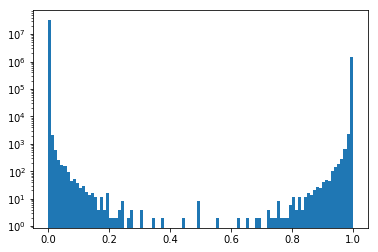

In [16]:
inv_dmats = 1. / (1e-2 + dmats)**2
inv_dmats /= inv_dmats.sum(axis=2, keepdims=True)
_ = plt.hist(inv_dmats.ravel(), bins=100, log=True)

Let's delete the raw train data so that we don't use it by mistake.

In [17]:
del train

The transformer relies on layer normalization rather than batch normalization.  I borrowed an implemententation from github.

In [18]:
from keras import backend as K

class LayerNormalization(keras.layers.Layer):

    def __init__(self,
                 center=True,
                 scale=True,
                 epsilon=None,
                 gamma_initializer='ones',
                 beta_initializer='zeros',
                 gamma_regularizer=None,
                 beta_regularizer=None,
                 gamma_constraint=None,
                 beta_constraint=None,
                 **kwargs):
        """Layer normalization layer
        See: [Layer Normalization](https://arxiv.org/pdf/1607.06450.pdf)
        :param center: Add an offset parameter if it is True.
        :param scale: Add a scale parameter if it is True.
        :param epsilon: Epsilon for calculating variance.
        :param gamma_initializer: Initializer for the gamma weight.
        :param beta_initializer: Initializer for the beta weight.
        :param gamma_regularizer: Optional regularizer for the gamma weight.
        :param beta_regularizer: Optional regularizer for the beta weight.
        :param gamma_constraint: Optional constraint for the gamma weight.
        :param beta_constraint: Optional constraint for the beta weight.
        :param kwargs:
        """
        super(LayerNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.center = center
        self.scale = scale
        if epsilon is None:
            epsilon = K.epsilon() * K.epsilon()
        self.epsilon = epsilon
        self.gamma_initializer = keras.initializers.get(gamma_initializer)
        self.beta_initializer = keras.initializers.get(beta_initializer)
        self.gamma_regularizer = keras.regularizers.get(gamma_regularizer)
        self.beta_regularizer = keras.regularizers.get(beta_regularizer)
        self.gamma_constraint = keras.constraints.get(gamma_constraint)
        self.beta_constraint = keras.constraints.get(beta_constraint)
        self.gamma, self.beta = None, None

    def get_config(self):
        config = {
            'center': self.center,
            'scale': self.scale,
            'epsilon': self.epsilon,
            'gamma_initializer': keras.initializers.serialize(self.gamma_initializer),
            'beta_initializer': keras.initializers.serialize(self.beta_initializer),
            'gamma_regularizer': keras.regularizers.serialize(self.gamma_regularizer),
            'beta_regularizer': keras.regularizers.serialize(self.beta_regularizer),
            'gamma_constraint': keras.constraints.serialize(self.gamma_constraint),
            'beta_constraint': keras.constraints.serialize(self.beta_constraint),
        }
        base_config = super(LayerNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        return input_mask

    def build(self, input_shape):
        shape = input_shape[-1:]
        if self.scale:
            self.gamma = self.add_weight(
                shape=shape,
                initializer=self.gamma_initializer,
                regularizer=self.gamma_regularizer,
                constraint=self.gamma_constraint,
                name='gamma',
            )
        if self.center:
            self.beta = self.add_weight(
                shape=shape,
                initializer=self.beta_initializer,
                regularizer=self.beta_regularizer,
                constraint=self.beta_constraint,
                name='beta',
            )
        super(LayerNormalization, self).build(input_shape)

    def call(self, inputs, training=None):
        mean = K.mean(inputs, axis=-1, keepdims=True)
        variance = K.mean(K.square(inputs - mean), axis=-1, keepdims=True)
        std = K.sqrt(variance + self.epsilon)
        outputs = (inputs - mean) / std
        if self.scale:
            outputs *= self.gamma
        if self.center:
            outputs += self.beta
        return outputs

Before building the model, let's define the target and the metric.  

In [19]:
y_mae = train_reorient['Yards'].values[::22]
y_mean = np.median(y_mae)
y_crps = np.zeros(shape=(y_mae.shape[0], 199))
for i,yard in enumerate(y_mae):
    y_crps[i, yard+99:] = 1
    
yardline = train_reorient['YardLine_std'].values[::22]

In [20]:
def crps(y_true, y_pred):
    stops = np.arange(-99, 100)
    unit_steps = stops >= y_true.reshape(-1, 1)
    crps = np.mean((y_pred - unit_steps)**2)
    return crps

The output of our model must be non decreasing.  One way to achieve this is to run an [isotonic regression](https://scikit-learn.org/stable/auto_examples/plot_isotonic_regression.html).

In [21]:
def nondecreasing(x):
    X_ir = np.arange(199).astype('float64')
    ir = IsotonicRegression(0, 1)
    x = ir.fit_transform(X_ir, x.astype('float64'))        
    return x

Let's now implement our model.  Its high level architecture is inspired by the transformer architecture:

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F75976%2Fe50d024a978c324b67182a554a2b66bd%2Ftransformer.png?generation=1575305725966574&amp;alt=media)

We start wiht embeddings, then a distance attention bloc, then a transformer encoder bloc with multi head self attention followed by a feed forward bloc. Then we plug the output into an encoder/decoder attention on the play embeddings.  Its output is fed to two output layers that output probabilities.  More can be found in my [competition writeup](https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/119430).

In [22]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Add, Multiply, Dot
from keras.layers import Embedding, Permute, Reshape
from keras.layers.core import Dropout, Lambda, Dense, Flatten
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD, Nadam
from keras import backend as K

from keras.engine.topology import Layer
import tensorflow as tf

We defined a custom layer that takes 4 numbers as input and outputs a logistic distribution.

In [23]:
class ScaleLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(ScaleLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(ScaleLayer, self).build(input_shape) 

    def call(self, x):
        xx = K.arange(-99, 100, dtype=tf.float32)
        mu = y_mean + tf.reshape(x[:, 0], (-1, 1))
        sigma_minus = tf.identity(K.exp(0.5 * tf.reshape(x[:, 1], (-1, 1))), name="sigma")
        sigma_plus = tf.identity(K.exp(0.5 * tf.reshape(x[:, 2], (-1, 1))), name="sigma")
        xx = tf.subtract(xx, mu)
        pcf = tf.where(xx >= 0, tf.divide (xx, sigma_plus),  tf.divide (xx, sigma_minus))
        return pcf

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

The next piece is a distance attention. To update a given player embedding I use a weighted sum of the other players embeddings. The weight depends on the distance. I tried various ways, and a normalized squared inverse was best. I was about to try other transforms when I decided to have them learnt by the model, via a 1x1 convolution bloc on the data. 

In [24]:
def dist_mult(dist, players):
    res = Lambda(lambda c: K.batch_dot(c[0], c[1]))([dist, players])
    return res

def dist_attention(dist, players, dropout):
    if 1:
        dist1 = Reshape((22, 22, 1))(dist)
        dist1 = Conv2D(16, 1, activation='relu', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(dist1)
        dist1 = Conv2D(1, 1, activation='relu', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(dist1)
        dist1 = Reshape((22, 22))(dist1)
        dist = Add()([dist, dist1])
    dist = LayerNormalization()(dist)
    att = dist_mult(dist, players, )
    x_player = Add()([players, att])
    x_player = LayerNormalization()(x_player)
    if dropout > 0:
        x_player = Dropout(dropout)(x_player)
    return x_player


The next bloc is multi head attention.  I recommend these two tutorials to understand the logic behind the code:

http://jalammar.github.io/illustrated-transformer/

https://nlp.seas.harvard.edu/2018/04/03/attention.html


There are two variants of multi head attention. The first one is self attention, used in the encoder part of the transformer. Here we use it on an array of player features.  The second variant is used in the decoder transformer. Here we use it with the play embeddings and the output of the encoder part.

In [25]:
def attention(x_inner, x_outer, n_factor, dropout):
    x_Q =  Conv1D(n_factor, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_inner)
    x_K =  Conv1D(n_factor, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_outer)
    x_V =  Conv1D(n_factor, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_outer)
    x_KT = Permute((2, 1))(x_K)
    res = Lambda(lambda c: K.batch_dot(c[0], c[1]) / np.sqrt(n_factor))([x_Q, x_KT])
    att = Lambda(lambda c: K.softmax(c, axis=-1))(res)
    att = Lambda(lambda c: K.batch_dot(c[0], c[1]))([att, x_V])
    return att

def multi_head_self_attention(x, n_factor, n_head, dropout):
    if n_head == 1:
        att = attention(x, x, n_factor, dropout)
    else:
        n_factor_head = n_factor // n_head
        heads = [attention(x, x, n_factor_head, dropout) for i in range(n_head)]
        att = Concatenate()(heads)
        att = Dense(n_factor, 
                      kernel_initializer='glorot_uniform',
                      bias_initializer='glorot_uniform',
                     )(att)
    x = Add()([x, att])
    x = LayerNormalization()(x)
    if dropout > 0:
        x = Dropout(dropout)(x)
    return x

def multi_head_outer_attention(x_inner, x_outer, n_factor, n_head, dropout):
    if n_head == 1:
        att = attention(x_inner, x_outer, n_factor, dropout)
    else:
        n_factor_head = n_factor // n_head
        heads = [attention(x_inner, x_outer, n_factor_head, dropout) for i in range(n_head)]
        att = Concatenate()(heads)
        att = Dense(n_factor, 
                      kernel_initializer='glorot_uniform',
                      bias_initializer='glorot_uniform',
                     )(att)
    x_inner = Add()([x_inner, att])
    x_inner = LayerNormalization()(x_inner)
    if dropout > 0:
        x = Dropout(dropout)(x_inner)
    return x

The next bloc is a position based feed forward network.  As noted in the original transformer paper, this is equivalent to a 1D convolution bloc, which is what we use here.  I added squeeze ande excitation, it improves performance a bit.

In [26]:
def se_bloc(in_bloc, ch, ratio):
    x = GlobalAveragePooling1D()(in_bloc)
    x = Dense(ch//ratio, activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = Multiply()([in_bloc, x])
    return Add()([x, in_bloc])

def conv_bloc(players, n_factor, n_hidden, se_ratio, dropout):
    players0 = players
    players = Conv1D(n_hidden, 1, activation='relu', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(players)
    players = Conv1D(n_factor, 1, activation='relu', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(players)
    players = Add()([players0, players])
    players = se_bloc(players, n_factor, se_ratio)
    players = LayerNormalization()(players)
    if dropout > 0:
        players = Dropout(dropout)(players)
    return players

We can now build our model with these blocs.

In [27]:
def get_model(n_player, n_factor, n_loop, n_head, n_hidden, se_ratio, dropout, n_player_cols, n_play_cols):
    input_players = Input((n_player, n_player_cols), name="players")
    input_dmats = Input((n_player, n_player), name="inv_dist")
    input_play = Input((n_play_cols,), name="plays")

    x_player = input_players
    x_player = Conv1D(n_factor, 1)(x_player)    
    x_player = LayerNormalization()(x_player)

    for l in range(n_loop):
        x_player = dist_attention(input_dmats, x_player, dropout)
        x_player = conv_bloc(x_player, n_factor, n_hidden, se_ratio, dropout)

        x_player = multi_head_self_attention(x_player, n_factor, n_head, dropout)
        x_player = conv_bloc(x_player, n_factor, n_hidden, se_ratio, dropout)

    x_play = Dense(n_factor)(input_play)
    x_play = Reshape((1, -1))(x_play)
    
    readout = multi_head_outer_attention(x_play, x_player, n_factor, n_head, dropout)
    readout = Flatten()(readout)

    out1 = Dense(199, activation='sigmoid')(readout)
    readout = Dense(4)(readout)
    readout = ScaleLayer(output_dim=199)(readout)
    out2 = keras.layers.Activation('sigmoid')(readout)
    return Model(inputs=[input_players, input_dmats, input_play], outputs=[out1, out2])


Let's test the code.

In [28]:
n_player = 22
n_factor = 64
se_ratio = 4
n_loop = 1
n_head = 4
n_hidden = 2*n_factor
dropout = 0.25
n_player_cols = len(player_cols)
n_play_cols = len(play_cols)
model = get_model(n_player, n_factor, n_loop, n_head, n_hidden, se_ratio, dropout, n_player_cols, n_play_cols)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inv_dist (InputLayer)           (None, 22, 22)       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 22, 22, 1)    0           inv_dist[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 22, 22, 16)   32          reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 22, 22, 1)    17          conv2d_1[0][0]                   
____________________________________________________________________________________________

At some point during our development we simulated the public test leaderboard by using that last 10% of the data for test, and the prevoous 90% for cross validation.  That code my not be up to date now.

In [29]:
simulate_test = False

if simulate_test:
    len_data = X_players.shape[0]
    len_train = int(0.9 * len_data)
else:
    len_data = X_players.shape[0]
    len_train = len_data

X_players_train, X_players_test = X_players[:len_train], X_players[len_train:]
inv_dmats_train, inv_dmats_test = inv_dmats[:len_train], inv_dmats[len_train:]
X_play_train, X_play_test = X_play[:len_train], X_play[len_train:]
y_mae_train, y_mae_test = y_mae[:len_train], y_mae[len_train:]
y_crps_train, y_crps_test = y_crps[:len_train], y_crps[len_train:]
yardline_train, yardline_test = yardline[:len_train], yardline[len_train:]

We can now define our folds.  As said above, we used 2017 only for training folds, and build validation folds out of the remaining data.  We also downweight 2017 samples by 0.5.  The folds take data augmentation into account: plays derived from an original train play are put in the same fold as the original.

In [30]:
kf = KFold(n_splits=12, shuffle=False)
ind_2017 = np.arange(len_2017)
def add_2017(x,y):
    x = np.concatenate((ind_2017, x +  len_2017))
    y = y + len_2017
    return x,y

indices = [add_2017(x, y) for x, y in kf.split(X_players_train[len_2017:len_train_reorient], 
                                               y_mae_train[len_2017:len_train_reorient])]

n_steps = len(time_steps)

def augment_indices(x, y, time_steps):
    x_a = np.concatenate([x + i*len_train_reorient for i in range(n_steps)])
    y_a = np.concatenate([y + i*len_train_reorient for i in range(n_steps)])
    return x_a, y_a

indices = [augment_indices(x, y, time_steps) for x,y in indices ]
indices = [(i, ind) for i,ind in enumerate(indices)]

w = np.ones(len_train_reorient)
w[:len_2017] = 0.5
w = np.concatenate([w for i in range(n_steps)])

We run our non decreasing code.  We also fix to 0 or 1 values that are always known. Last, given we use TTA, i.e. we augment data at prediction time, we take the average of predictions.  

In [31]:
def post_process(y_pred, yardline_train, time_steps):
    upper = 100 - yardline_train
    lower = - yardline_train
    for i in range(y_pred.shape[0]):
        y_pred[i, 99 + upper[i]:] = 1
        y_pred[i, :99 + lower[i]] = 0
        y_pred[i] = nondecreasing(y_pred[i].ravel())
    if 1:
        n_steps = len(time_steps)
        len_y_pred = len(y_pred) // n_steps
        y_pred = np.mean([y_pred[len_y_pred * i: len_y_pred * (i+1)] for i in range(n_steps)], axis=0) 
    return y_pred

Due to time limit we only run two folds here.  During mdodel development we used 12 folds, which proved to be quite in line with LB.

In [32]:
name = 'nn'
results[name] = {'crps': [], 'y_test': [], 'imp': [], 'models': []}

try:
    del sess
except:
    pass

sess = init_seeds(0)

pred_test = []


for index in indices:
    if 0 and index[0] < 10:
        continue
    train_idx, val_idx = index[1]
    train_players, train_inv_dmats, train_play, train_y, = (X_players_train[train_idx], 
                                                            inv_dmats_train[train_idx], 
                                                            X_play_train[train_idx], 
                                                            y_crps_train[train_idx],) 
    val_players, val_inv_dmats, val_play, val_y, = (X_players_train[val_idx], 
                                                    inv_dmats_train[val_idx], 
                                                    X_play_train[val_idx], 
                                                    y_crps_train[val_idx], )
    w_train = w[train_idx]

    n_player = 22
    n_factor = 64
    se_ratio = 2
    n_loop = 1
    n_head = 4
    n_hidden = 2*n_factor
    dropout = 0.25
    n_player_cols = len(player_cols)
    n_play_cols = len(play_cols)
    model = get_model(n_player, n_factor, n_loop, n_head, n_hidden, se_ratio, dropout, n_player_cols, n_play_cols)
    
    if 1:
        opm = keras.optimizers.Adam(lr=1e-3)
        #opm = RAdam(warmup_proportion=0.1, min_lr=1e-5)
        model.compile(loss='mse', optimizer=opm, metrics=[])
        es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                           restore_best_weights=True, verbose=0, patience=21)
        lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=0, mode='min', min_delta=0.00001)
        history = model.fit([train_players, train_inv_dmats, train_play], [train_y, train_y], 
                        verbose=2, batch_size=256, epochs=500, 
                        callbacks=[es,lr], 
                        validation_data=[[val_players, val_inv_dmats, val_play], [val_y, val_y]],
                        sample_weight=[w_train, w_train])
    
    X_ir = np.arange(199).astype('float64')
    #print(val_players.shape, val_inv_dmats.shape)

    y_pred = model.predict([val_players, val_inv_dmats, val_play])
    y_pred = (y_pred[0]+y_pred[1])/2.
    score0 = crps(y_mae_train[val_idx], y_pred)
    y_pred = post_process(y_pred, yardline_train[val_idx], time_steps)
    score1 = crps(y_mae_train[val_idx][:len(y_pred)], y_pred)
    print(' val fold:', index[0], score0)
    print(' val fold:', index[0], score1)
    if score0 < score1:
        break
    results[name]['models'].append(model)
    results[name]['crps'].append(score1)
    #results[name]['imp'].append(model.feature_importances_)
    if simulate_test:
        y_pred = model.predict([X_players_test, inv_dmats_test, X_play_test])
        y_pred = (y_pred[0]+y_pred[1])/2.
        score0 = crps(y_mae_test, y_pred)
        y_pred = post_process(y_pred, yardline_test, time_steps)
        score1 = crps(y_mae_test[:len(y_pred)], y_pred)
        print('test fold:', index[0], score0)
        print('test fold:', index[0], score1)
        pred_test.append(y_pred)
    print('*' * 40)
print('Folds:', results[name]['crps'])
print('Average:', np.mean(results[name]['crps']))

Train on 66693 samples, validate on 2820 samples
Epoch 1/500
 - 19s - loss: 0.0336 - dense_17_loss: 0.0227 - activation_2_loss: 0.0109 - val_loss: 0.0274 - val_dense_17_loss: 0.0133 - val_activation_2_loss: 0.0130
Epoch 2/500
 - 13s - loss: 0.0213 - dense_17_loss: 0.0107 - activation_2_loss: 0.0105 - val_loss: 0.0266 - val_dense_17_loss: 0.0128 - val_activation_2_loss: 0.0127
Epoch 3/500
 - 14s - loss: 0.0206 - dense_17_loss: 0.0104 - activation_2_loss: 0.0103 - val_loss: 0.0264 - val_dense_17_loss: 0.0126 - val_activation_2_loss: 0.0126
Epoch 4/500
 - 12s - loss: 0.0203 - dense_17_loss: 0.0102 - activation_2_loss: 0.0102 - val_loss: 0.0261 - val_dense_17_loss: 0.0126 - val_activation_2_loss: 0.0126
Epoch 5/500
 - 13s - loss: 0.0201 - dense_17_loss: 0.0101 - activation_2_loss: 0.0101 - val_loss: 0.0258 - val_dense_17_loss: 0.0124 - val_activation_2_loss: 0.0123
Epoch 6/500
 - 13s - loss: 0.0200 - dense_17_loss: 0.0100 - activation_2_loss: 0.0100 - val_loss: 0.0256 - val_dense_17_loss: 

Let's delete our training data to make sure we don't use it anymore.

In [33]:
del train_reorient

The rest of the code computes submission.  It performs the same data cleaning and data augmentation than was done on training data.

In [34]:
from tqdm import tqdm

env = nflrush.make_env()
iter_test = env.iter_test()


In [35]:
for (test_df, sample_prediction_df) in tqdm(iter_test):
    test_reorient = reorient(test_df.copy(), flip_left=True)
    test_reorient = augment_data(test_reorient, time_steps)
    df = test_reorient[player_cols]
    X_players = df.values.astype('float32') 
    X_players = ss_players.transform(df)
    X_players = X_players.reshape((-1, 22, len(player_cols)))
    X,Y = test_reorient.X.values, test_reorient.Y.values
    dmats = [get_dmat(X[i:i+22], Y[i:i+22]) for i in range(0, test_reorient.shape[0], 22)]
    dmats = np.vstack(dmats).reshape((-1, 22, 22))   
    inv_dmats = 1. / (1e-2 + dmats)**2
    inv_dmats /= inv_dmats.sum(axis=2, keepdims=True)    
    X_play = test_reorient[play_cols].values[::22]
    X_play = ss_play.transform(X_play)    
    yardline = test_reorient['YardLine_std'].values[::22]
    y_preds = [model.predict([X_players, inv_dmats, X_play]
                            ) for model in results[name]['models']]
    y_preds = [(pred[0] + pred[1]) / 2. for pred in y_preds]
    y_pred = np.mean(y_preds, axis=0)
    y_pred = post_process(y_pred, yardline, time_steps)
    sample_prediction_df.iloc[0, :] = y_pred.ravel()
    env.predict(sample_prediction_df)
env.write_submission_file()

3438it [28:50,  1.99it/s]


Your submission file has been saved!  Once you `Commit` your Notebook and it finishes running, you can submit the file to the competition from the Notebook Viewer `Output` tab.


In [36]:
 y_pred.shape

(1, 199)

In [37]:
test_reorient.shape

(66, 64)

In [38]:
X,Y = test_reorient.X.values, test_reorient.Y.values
dmats = [get_dmat(X[i:i+22], Y[i:i+22]) for i in range(0, test_reorient.shape[0], 22)]
dmats = np.vstack(dmats).reshape((-1, 22, 22))
dmats.shape

(3, 22, 22)